# 5章 教師あり学習：回帰

## 5.1 １次元入力の直線モデル

In [206]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
# 教師データ作成

np.random.seed(seed=1) # 乱数を固定

X_min = 4 # Xの加減
X_max = 30 # Xの上限
X_n = 16 # データの個数

X = 5 + 25 * np.random.rand(X_n) # 年齢Xの生成
Prm_c = [170, 108, 0.2] # 生成パラメータ

# 身長の式
# 170 - 108 * exp(-0.2X) + 4 * 標準正規分布に従う16個の数(np.randn)
T = Prm_c[0] - Prm_c[1] * np.exp(-Prm_c[2] * X) + 4 * np.random.randn(X_n)

# 複数のndarrayをnpzで保存
np.savez('ch5_data.npz', X = X, X_min = X_min, X_max = X_max, X_n = X_n, T = T)

In [208]:
X

array([15.42555012, 23.00811234,  5.00285937, 12.55831432,  8.66889727,
        7.30846487,  9.65650528, 13.63901818, 14.91918686, 18.47041835,
       15.47986286, 22.13048751, 10.11130624, 26.95293591,  5.68468983,
       21.76168775])

In [209]:
T

array([170.91013145, 160.67559882, 129.00206616, 159.70139552,
       155.46058905, 140.56134369, 153.65466385, 159.42939554,
       164.70423898, 169.64527574, 160.71257522, 173.28709855,
       159.31193249, 171.51757345, 138.9570433 , 165.8744074 ])

In [210]:
# 小数点以下第二位で四捨五入
np.round(X, 2)

array([15.43, 23.01,  5.  , 12.56,  8.67,  7.31,  9.66, 13.64, 14.92,
       18.47, 15.48, 22.13, 10.11, 26.95,  5.68, 21.76])

In [211]:
np.round(T, 2)

array([170.91, 160.68, 129.  , 159.7 , 155.46, 140.56, 153.65, 159.43,
       164.7 , 169.65, 160.71, 173.29, 159.31, 171.52, 138.96, 165.87])

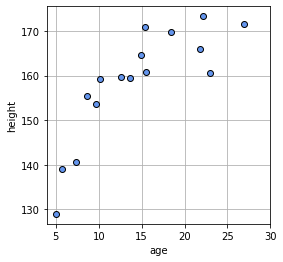

In [212]:
# グラフに表示
plt.figure(figsize=(4,4))
plt.plot(X, T, marker='o', linestyle='None', markeredgecolor='black', color='cornflowerblue')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.xlabel('age')
plt.ylabel('height')
plt.show()

### 5.1.1 直線モデル

$y(x)=w_0x+w_1$

### 5.1.2 二乗誤差関数

$\displaystyle J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n-t_n)^2$

- $J$は平均二乗誤差（mean squared error, MSE）という

In [213]:
from mpl_toolkits.mplot3d import Axes3D

In [214]:
# 誤差関数の定義
def mse_line(x,t,w):
    y = w[0]*x + w[1]
    mse = np.mean((y-t)**2)
    return mse

In [215]:
xn = 100 # 等高線表示の解像度
w0_range = [-25, 25]
w1_range = [120, 170]

# linspace(start,stop,num)で等差数列を作成
w0 = np.linspace(w0_range[0], w0_range[1], xn)
w1 = np.linspace(w1_range[0], w1_range[1], xn)

# 格子列を作成
ww0, ww1 = np.meshgrid(w0, w1)

In [216]:
# 参考
print('linspace','w0='+str(w0.shape),'w1='+str(w1.shape))
print('meshgrid','ww0='+str(ww0.shape),'ww1='+str(ww1.shape))

linspace w0=(100,) w1=(100,)
meshgrid ww0=(100, 100) ww1=(100, 100)


In [217]:
# 格子点に基づく平均二乗誤差の計算結果をJ[i1, i0]に入れる
J = np.zeros((len(w0), len(w1)))
for i0 in range(len(w0)):
    for i1 in range(len(w1)):
        J[i1, i0] = mse_line(X, T, (w0[i0], w1[i1]))

In [218]:
J.shape

(100, 100)

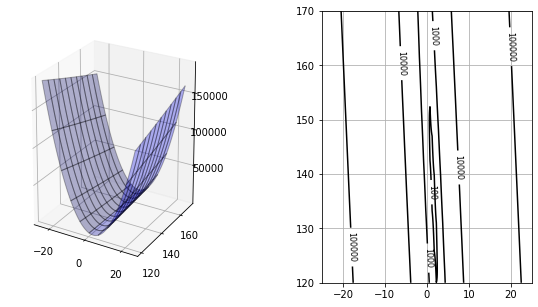

In [219]:
# 可視化

# グラフのサイズ
plt.figure(figsize=(9.4,5))

# グラフの余白、幅を調整する
# wspace : the amount of width reserved for space between subplots,
plt.subplots_adjust(wspace=0.5)

# subplot(行数、列数、数)
ax = plt.subplot(1,2,1,projection='3d')

# ３次元のグラフを作成する 
ax.plot_surface(ww0, ww1, J, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')

# 目盛りの調整
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120, 140, 160])
ax.view_init(20, -60)

# 等高線の表示
plt.subplot(1, 2, 2)
cont = plt.contour(ww0, ww1, J, 30, colors='black',levels=[100, 1000, 10000, 100000])
cont.clabel(fmt='%d', fontsize=8)
plt.grid(True)
plt.show()

### 5.1.3 パラメータを求める（勾配法）

In [220]:
# 平均二乗誤差の勾配
def dmse_line(x, t, w):
    y = w[0] * x + w[1]
    d_w0 = 2 * np.mean((y-t)*x)
    d_w1 = 2 * np.mean(y-t)
    return d_w0, d_w1

In [221]:
# w = [10,165の勾配]
d_w = dmse_line(X,T,[10,165])
print(np.round(d_w,1))

[5046.3  301.8]


In [222]:
# 勾配法
def fit_line_num(x, t):
    w_init = [10.0, 165.0] #初期パラメータ
    alpha = 0.001 # 学習率
    tau_max = 100000 # 繰り返しの最大数
    eps = 0.1 # 繰り返しをやめる勾配の絶対値のしきい値
    w_hist = np.zeros([tau_max, 2])
    w_hist[0, :] = w_init # wの初期値をw_histに代入
    
    for tau in range(1, tau_max):
        dmse = dmse_line(x, t, w_hist[tau - 1])
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        if max(np.absolute(dmse)) < eps: # 終了判定
            break
    
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w_hist = w_hist[:tau, :]
    
    return w0, w1, dmse, w_hist

繰り返し回数13820
W=[-0.005794, 0.099991]
MSE=49.027452


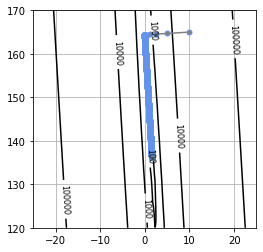

In [223]:
plt.figure(figsize=(4,4))
# MSEの等高線表示

wn = 100 # 等高線解像度
w0_range = [-25, 25]
w1_range = [120, 170]

w0 = np.linspace(w0_range[0], w0_range[1], wn)
w1 = np.linspace(w1_range[0], w1_range[1], wn)

ww0, ww1 = np.meshgrid(w0, w1)

J = np.zeros((len(w0),len(w1)))

for i0 in range(wn):
    for i1 in range(wn):
        J[i1, i0] = mse_line(X, T, (w0[i0], w1[i1]))
cont = plt.contour(ww0, ww1, J, 30, colors='black', levels=(100,1000,10000,100000))
cont.clabel(fmt='%1.0f',fontsize=8)
plt.grid(True)

# 勾配法呼び出し
W0, W1, dMSE, W_history = fit_line_num(X, T)

# 結果表示
print('繰り返し回数{0}'.format(W_history.shape[0]))
print('W=[{0:.6f}, {1:.6f}]'.format(dMSE[0],dMSE[1]))
print('MSE={0:.6f}'.format(mse_line(X,T,[W0,W1])))

plt.plot(W_history[:,0], W_history[:,1], '.-', color='gray', markersize=10, markeredgecolor='cornflowerblue')
plt.show()

w0=1.540, w1=136.176
SD=7.002 cm


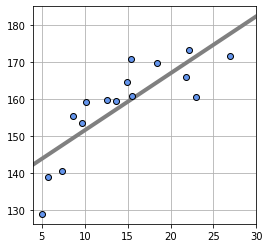

In [224]:
# 線の表示
def show_line(w):
    xb = np.linspace(X_min, X_max, 100)
    y = w[0] * xb + w[1]
    plt.plot(xb, y, color=(.5, .5, .5), linewidth=4)

plt.figure(figsize=(4, 4))
W = np.array([W0, W1])
mse = mse_line(X, T, W)
print('w0={0:.3f}, w1={1:.3f}'.format(W0, W1))
print('SD={0:.3f} cm'.format(np.sqrt(mse)))
show_line(W)
plt.plot(X, T, marker='o',linestyle='None', color='cornflowerblue',markeredgecolor='black')
plt.xlim(X_min,X_max)
plt.grid(True)
plt.show()


### 5.1.4 直線モデルパラメータの解析解

In [225]:
# 解析解を求める
def fit_line(x,t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t*x)
    mxx = np.mean(x*x)
    w0 = (mtx - mt * mx) / (mxx - mx**2)
    w1 = mt - w0 * mx
    return np.array([w0,w1])

w0=1.558, w1=135.872
SD=7.001cm


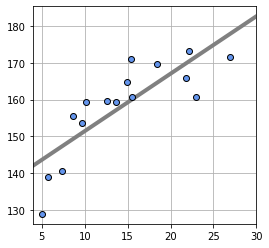

In [226]:
W = fit_line(X, T)
print('w0={0:.3f}, w1={1:.3f}'.format(W[0],W[1]))
mse = mse_line(X, T, W)
print('SD={0:.3f}cm'.format(np.sqrt(mse)))
plt.figure(figsize=(4,4))
show_line(W)
plt.plot(X, T, marker='o',linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

## 5.2 ２次元入力の面モデル

In [227]:
# 二次元データ作成
X0 = X
X0_min = 5
X0_max = 30
np.random.seed(seed=1) # 乱数を固定
X1 = 23 * (T / 100) ** 2 + 2 * np.random.randn(X_n)
X1_min = 40
X1_max = 75

In [228]:
print(np.round(X0,2))
print(np.round(X1,2))
print(np.round(T,2))

[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
[70.43 58.15 37.22 56.51 57.32 40.84 57.79 56.94 63.03 65.69 62.33 64.95
 57.73 66.89 46.68 61.08]
[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


In [231]:
# ２次元データの表示
def show_data2(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot([x0[i],x0[i]],[x1[i],x1[i]], [120,t[i]], color='gray')
    ax.plot(x0,x1,t,'o',color='cornflowerblue', markeredgecolor='black',markersize=6,markeredgewidth=0.5)
    ax.view_init(elev=35,azim=-75)

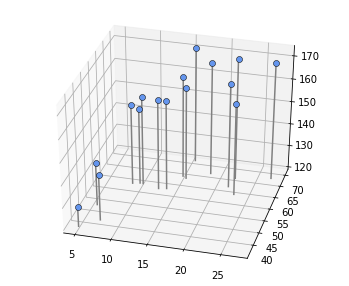

In [232]:
plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1,projection='3d')
show_data2(ax,X0,X1,T)
plt.show()

### 5.2.1 データの表し方